In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from drn_interactions.brain_state_decode import StateDecodeDataLoader, StateDecodePreprocessor, StateEncoder, PreprocessingError
from drn_interactions.load import load_derived_generic, load_neurons_derived

import lightgbm as lgb
from sklearn.compose import TransformedTargetRegressor

sns.set_theme(context="talk", style="ticks")

%load_ext autoreload
%autoreload 2


c:\Users\roryl\.conda\envs\drn38\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from typing import Optional, Tuple

def eeg_encode(
    loader: StateDecodeDataLoader,
    preprocessor:StateDecodePreprocessor,
    encoder: StateEncoder,
    run_pop: bool = True,
    run_state: bool = False,
    run_comb: bool = False,
    ) -> pd.DataFrame:
    spikes, states = loader()
    spikes, states = preprocessor(spikes, states)
    spikes.columns = spikes.columns.map(str)
    
    frames = []
    if run_pop:
        encoder.run_pop(spikes, states)
        pop = encoder.get_pop_scores()
        df_pop = pd.DataFrame(pop).mean().to_frame("pop").reset_index().rename({"index": "neuron_id"}, axis=1)
        frames.append(df_pop)
    if run_state:
        encoder.run_state(spikes, states)
        state = encoder.get_state_scores()
        df_state = pd.DataFrame(state).mean().to_frame("state").reset_index().rename({"index": "neuron_id"}, axis=1)
        frames.append(df_state)
    if run_comb:
        encoder.run_combined(spikes, states)
        comb = encoder.get_combined_scores()
        df_comb = pd.DataFrame(comb).mean().to_frame("comb").reset_index().rename({"index": "neuron_id"}, axis=1)
        frames.append(df_comb)


    df_out = frames[0]
    for frame in frames[1:]:
        df_out = df_out.merge(frame)
    
    return df_out

def eeg_encode_limit(
    loader: StateDecodeDataLoader,
    preprocessor:StateDecodePreprocessor,
    encoder: StateEncoder,
    max_features: int = None,
    min_features: int = 1
):
    spikes, states = loader()
    spikes, states = preprocessor(spikes, states)
    spikes.columns = spikes.columns.map(str)
    encoder.run_limit(spikes, states, min_features=min_features, max_features=max_features)
    limit = encoder.get_limit_scores()
    df_limit = pd.DataFrame(limit)
    df_limit = df_limit.reset_index().rename({"index": "n_best"}, axis=1)
    df_limit = df_limit.melt(id_vars="n_best", var_name="neuron_id", value_name="score")
    return df_limit

def eeg_encode_dropout(
    loader: StateDecodeDataLoader,
    preprocessor:StateDecodePreprocessor,
    encoder: StateEncoder,
    clusters: pd.DataFrame,
):
    spikes, states = loader()
    spikes, states = preprocessor(spikes, states)
    spikes.columns = spikes.columns.map(str)
    encoder.run_dropout(spikes, states, clusters=clusters)
    drop = encoder.get_dropout_scores()
    df_drop = pd.DataFrame(drop)
    df_drop = df_drop.reset_index().rename({"index": "neuron_id"}, axis=1)
    df_drop = df_drop.melt(id_vars="neuron_id", var_name="wf_3", value_name="score")
    return df_drop


def eeg_encode_multi(
    sessions, 
    loader, 
    preprocessor, 
    encoder, 
    run_pop: bool = True,
    run_state: bool = False,
    run_comb: bool = False,
    verbose: bool =False):
    out = []
    for session in sessions:
        if verbose:
            print(session) 
        loader_session = deepcopy(loader)
        loader_session.set_session(session)
        try:
            df = eeg_encode(loader_session, preprocessor, encoder, run_pop=run_pop, run_state=run_state, run_comb=run_comb)
        except PreprocessingError as e:
            if verbose:
                print(f"{session}: {str(e)}")
            continue
        df = df.assign(session_name=session)
        out.append(df)
    return pd.concat(out).reset_index(drop=True)


def eeg_encode_multi_limit(
    sessions, 
    loader, 
    preprocessor, 
    encoder, 
    max_features: int = None,
    min_features: int = 1,
    verbose: bool =False
    ):
    out = []
    for session in sessions:
        if verbose:
            print(session) 
        loader_session = deepcopy(loader)
        loader_session.set_session(session)
        df = eeg_encode_limit(
            loader_session, 
            preprocessor, 
            encoder, 
            max_features=max_features,
            min_features=min_features
            )
        df = df.assign(session_name=session)
        out.append(df)
    return pd.concat(out).reset_index(drop=True)

def eeg_encode_multi_dropout(
    sessions, 
    loader, 
    preprocessor, 
    encoder, 
    clusters,
    verbose: bool =False
    ):
    out = []
    for session in sessions:
        if verbose:
            print(session) 
        loader_session = deepcopy(loader)
        loader_session.set_session(session)
        df = eeg_encode_dropout(
            loader_session, 
            preprocessor, 
            encoder, 
            clusters=clusters,
            )
        df = df.assign(session_name=session)
        out.append(df)
    return pd.concat(out).reset_index(drop=True)


def shuffle_cols(spikes, states):
    # breaks correlations, breaks associations with states
    spikes = spikes.apply(np.random.permutation)
    return spikes, states


def shuffle_rows(spikes, states):
    # maintains correlations, breaks associations with states
    spikes = spikes.copy().sample(frac=1)
    spikes.index = states.index
    return spikes, states


## Load Data

In [3]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})
neurons = load_neurons_derived()
sessions = neurons.merge(eeg_states[["session_name"]].drop_duplicates(), on="session_name")["session_name"].unique()

### Run Encoding Models

In [6]:
# default settings
ct = make_column_transformer(
    (
        StandardScaler(),
        make_column_selector(dtype_exclude=object)
    ),  
    (
        OneHotEncoder(drop="if_binary"),
        make_column_selector(dtype_include=object)
    ), 
)

estimator = make_pipeline(ct, 
    lgb.LGBMRegressor(
        n_estimators=20, 
        n_jobs=-1, 
        force_row_wise=True,
        reg_lambda=0.8,
        )
)

estimator = TransformedTargetRegressor(estimator, transformer=StandardScaler())

loader =StateDecodeDataLoader(
    session_name=sessions[8],
    block="pre",
    t_start=0,
    t_stop=1800,
    bin_width=1,
    )
preprocessor = StateDecodePreprocessor(thresh_empty=2)
cv = KFold(shuffle=True)
encoder = StateEncoder(
    estimator=estimator,
    cv=cv,
    verbose=False,
)

In [7]:
encoder_all = StateEncoder(
    estimator=estimator,
    cv=cv,
    verbose=False,
)

df_all = eeg_encode_multi(
    sessions,
    loader,
    preprocessor,
    encoder,
    run_pop=True,
    run_state=True,
    run_comb=True,
    verbose=False,
)

In [8]:
encoder_drop = StateEncoder(
    estimator=estimator,
    cv=cv,
    verbose=False,
)

df_drop = eeg_encode_multi_dropout(
    sessions,
    loader,
    preprocessor,
    encoder_drop,
    clusters=neurons,
    verbose=False,
)

100%|██████████| 3/3 [00:19<00:00,  6.35s/it]


In [13]:
encoder_limit = StateEncoder(
    estimator=estimator,
    cv=cv,
    verbose=False,
)

df_lim = eeg_encode_multi_limit(
    sessions=sessions,
    loader=loader,
    preprocessor=preprocessor,
    encoder=encoder_limit,
    max_features=None,
    verbose=False
)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_n

In [15]:
from drn_interactions.load import get_derived_data_dir

out_dir = get_derived_data_dir() / "encoding" / "brain state"
out_dir.mkdir(parents=True, exist_ok=True)


df_all.to_csv(out_dir / "encoding - brain state - All.csv", index=False)
df_lim.to_csv(out_dir / "encoding - brain state - Limit.csv", index=False)
df_drop.to_csv(out_dir / "encoding - brain state - Drop Out.csv", index=False)

<Figure size 432x288 with 0 Axes>

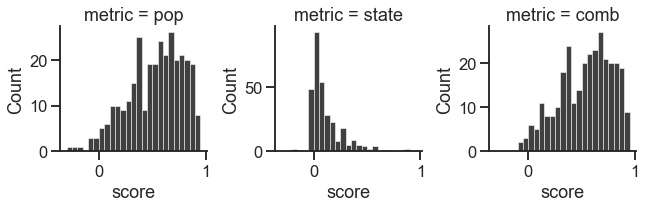

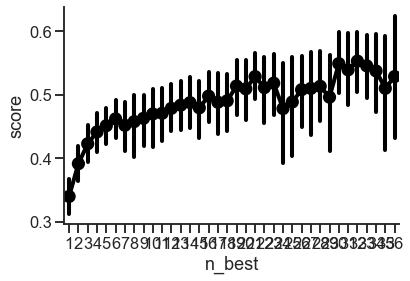

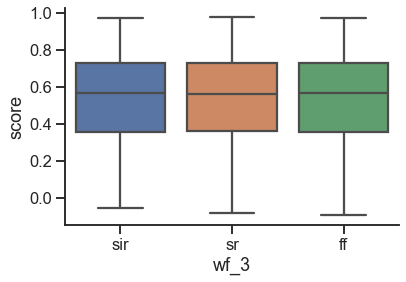

In [14]:
# plots

plt.figure()
dfp = df_all.melt(
    id_vars=["session_name", "neuron_id"], 
    var_name="metric", 
    value_name="score"
    )

g = sns.FacetGrid(dfp, col="metric", height=3,     sharey=False,)
g.map_dataframe(
    sns.histplot, 
    x="score", 
    color="black",
    bins=np.arange(-0.3, 1, 0.05),

    )
g.add_legend()

plt.figure()
ax = sns.pointplot(
    data=df_lim, x="n_best", y="score", color="black",
    )
sns.despine(ax=ax)

plt.figure()
ax = sns.boxplot(data=df_drop.query("score > -0.1"), x="wf_3", y="score")
sns.despine(ax=ax)

#### Shuffles

In [8]:
# break all correlations
preprocessor_shuf_hard = StateDecodePreprocessor(thresh_empty=2, shuffle=shuffle_cols)
df_shuff_hard = eeg_encode_multi(sessions, loader, preprocessor_shuf_hard, encoder, verbose=True)

ESHOCK_03_LOC1
ESHOCK_04_LOC1
ESHOCK_06_LOC1
ESHOCK_07_LOC1
ESHOCK_08_LOC1
ESHOCK_09_LOC1
hamilton_10
hamilton_03
hamilton_04
hamilton_09
acute_15
acute_16
acute_14
acute_12
acute_11


## Plots

In [27]:
# State v Population 


# df_all = df_all.assign(shuffle_status="none")
# df_shuff_soft = df_shuff_soft.assign(shuffle_status="shuff_rows")
# df_shuff_hard = df_shuff_hard.assign(shuffle_status="shuff_cols")



# df = pd.concat([
#     df.melt(
#         id_vars=["neuron_id", "session_name", "shuffle_status"], 
#         var_name="encoder", 
#         value_name="r2"
#         ) 
#     for df in (df_all, df_shuff_soft, df_shuff_hard)]
#     )


Text(0.5, 0, '')

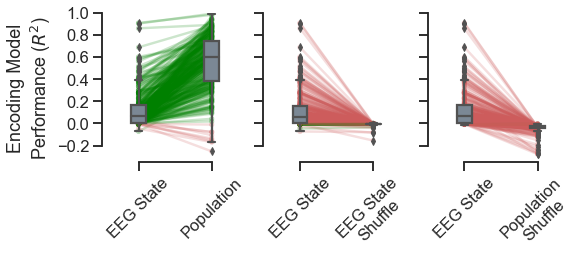

In [76]:
# # State v Population 
# def plot_boxes(ax_pop, ax_state, ax_shuff, df):
#     for ax in (ax_state, ax_pop, ax_shuff):
#         ax.set_ylim(-0.35, 1)
#         ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
#     pg.plot_paired(
#         data=df.query("shuffle_status == 'none' and encoder != 'comb' and r2 > -0.3"), 
#         dv='r2', 
#         within='encoder',
#         subject='neuron_id',
#         boxplot=True,
#         order=["state", "pop"],
#         boxplot_in_front=True,
#         pointplot_kwargs={"alpha": 0.2},
#         ax=ax_pop
#         )
#     ax_pop.set_ylabel("Encoding Model\nPerformance ($R^2$)")
#     ax_pop.set_xticklabels(["EEG State", "Population"], rotation=45)
#     ax_pop.set_xlabel("")
#     pg.plot_paired(
#         data=df.query("(shuffle_status == 'none' and encoder == 'state') or (shuffle_status == 'shuff_cols' and encoder == 'state')").query("r2 > -0.3"), 
#         dv='r2', 
#         within='shuffle_status',
#         subject='neuron_id',
#         boxplot=True,
#         # order=["state", "pop"],
#         boxplot_in_front=True,
#         pointplot_kwargs={"alpha": 0.2},
#         ax=ax_state
#         )
#     ax_state.set_xlabel("")
#     ax_state.set_xticklabels(["EEG State", "EEG State\nShuffle"], rotation=45)

#     pg.plot_paired(
#         data=df.query("(shuffle_status == 'none' and encoder == 'state') or (shuffle_status == 'shuff_cols' and encoder == 'pop') and r2 > -0.3"), 
#         dv='r2', 
#         within='encoder',
#         subject='neuron_id',
#         boxplot=True,
#         order=["state", "pop"],
#         boxplot_in_front=True,
#         pointplot_kwargs={"alpha": 0.2},
#         ax=ax_shuff
#         )
#     ax_shuff.set_xticklabels(["EEG State", "Population\nShuffle"], rotation=45)
#     ax_shuff.set_xlabel("")
#     return ax_pop, ax_state, ax_shuff

# fig = plt.figure(figsize=(8, 3.5), constrained_layout=True)

# (ax_pop, ax_state, ax_shuff) = fig.subplots(1, 3, sharey=True)
# (ax_pop, ax_state, ax_shuff) = plot_boxes(ax_pop, ax_state, ax_shuff, df)

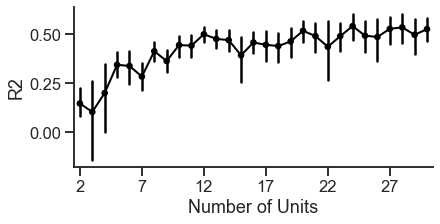

In [100]:
# def plot_performance_vs_n_units(df_pop_n, ax=None, **kwargs):
#     if ax is None:
#         _, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
#     sns.pointplot(
#         data=df_pop_n.reset_index(drop=True),
#         x="n_units",
#         y="pop",
#         color="black",
#         ax=ax,
#         scale=0.5,
#         errwidth=2.5,
#         **kwargs
#     )
#     ax.set_xlabel("Number of Units")
#     ax.set_ylabel("R2")
#     ax.xaxis.set_major_locator(plt.MultipleLocator(5))
#     sns.despine(ax=ax)
#     return ax


# _, ax_line = plt.subplots(figsize=(6, 3), constrained_layout=True)
# plot_performance_vs_n_units(df_limit_n, ax=ax_line)
# sns.despine(ax=ax_line)

(-0.5, 1.0)

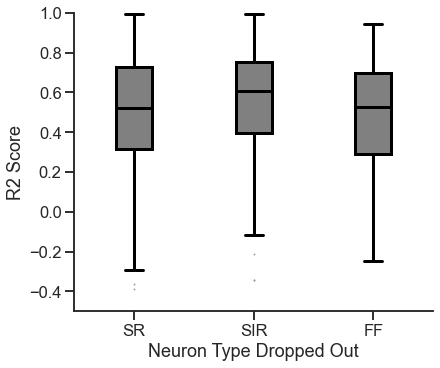

In [101]:
# def dropout_boxplots(df_pop_nt, ax=None):
#     PROPS = {
#         "boxprops": {"facecolor": "grey", "edgecolor": "black"},
#         "medianprops": {"color": "black"},
#         "whiskerprops": {"color": "black"},
#         "capprops": {"color": "black"},
#     }
#     if ax is None:
#         _, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
#     ax = sns.boxplot(
#         data=df_pop_nt.reset_index(drop=True),
#         x="dropout",
#         y="pop",
#         ax=ax,
#         color="white",
#         width=0.3,
#         fliersize=1,
#         linewidth=3,
#         **PROPS
#     )
#     ax.set_ylabel("R2 Score")
#     ax.set_xlabel("Neuron Type Dropped Out")
#     ax.set_xticklabels(["SR", "SIR", "FF"])
#     sns.despine(ax=ax)
#     return ax


# _, ax_box = plt.subplots(figsize=(6, 5), constrained_layout=True)
# dropout_boxplots(df_nt, ax=ax_box)
# ax_box.set_ylim(-0.5, 1)